Нужно придумать небольшую базу данных и написать к ней запросы.
В базе должно быть минимум 4 таблицы и хотя бы две связи вида one-to-many или many-to-many. Можно решить как при помощи pandas, так и при помощи SQL.
Запросы должны быть осмысленными и должны решать какую-то задачу.

<b>Easy</b>
Выгрузить данные и отфильтровать их по какому-то значению.
Пример запроса с БД, приведенной выше: вывести учителей старше 30 лет.

<b>Normal</b>
Написать запрос на объединение двух или более таблиц, также в запросе должна быть фильтрация
Пример запроса с БД, приведенной выше: найти имя учителя моложе 30 лет, который ведет математику

In [89]:
import numpy as np
import pandas as pd
import sqlite3
import random

In [90]:
sql = sqlite3.connect('database/trade.db')

In [91]:
commodities_names = ["Hill's", "1St Choice", "Royal Canin", "EUKANUBA", "Grandorf", "Farmina"]
commodities_prices = [250, 148, 185, 213, 348, 164]

companies_names = ["Zooptorg", "Филя", "PetShop", "Бетховен", "Четыре лапы"]
companies_INNs = ["7723517121", "7816407523","5032256149", "5032327858", "7801403117"]
commodities = pd.DataFrame({'commodity_name': commodities_names, 'price': commodities_prices})
companies = pd.DataFrame({'company_name': companies_names, 'INN':companies_INNs})
commodities.to_sql('commodities', sql, index_label='id', if_exists='replace')
companies.to_sql('companies', sql, index_label='id', if_exists='replace')
print (commodities)
print(companies)


  commodity_name  price
0         Hill's    250
1     1St Choice    148
2    Royal Canin    185
3       EUKANUBA    213
4       Grandorf    348
5        Farmina    164
  company_name         INN
0     Zooptorg  7723517121
1         Филя  7816407523
2      PetShop  5032256149
3     Бетховен  5032327858
4  Четыре лапы  7801403117


In [92]:
dates = ['22.10.2021', '22.10.2021', '23.10.2021','23.10.2021','23.10.2021','24.10.2021','24.10.2021','25.10.2021','25.10.2021','25.10.2021','25.10.2021','25.10.2021',
         '27.10.2021','28.10.2021','28.10.2021','28.10.2021','28.10.2021','28.10.2021','28.10.2021','29.10.2021']
numbers = [i for i in range(343,363)]
company_ids = np.random.randint(0, 5, size=20)
st = ['new', 'paid', 'shipped', 'completed']
statuses = np.random.choice(st, 20, replace=True, p=None)
documents = pd.DataFrame({'date':dates, 'number':numbers, 'company_id': company_ids, 'status':statuses})
print (documents)



          date  number  company_id     status
0   22.10.2021     343           3        new
1   22.10.2021     344           4    shipped
2   23.10.2021     345           4  completed
3   23.10.2021     346           2    shipped
4   23.10.2021     347           4        new
5   24.10.2021     348           1  completed
6   24.10.2021     349           1       paid
7   25.10.2021     350           1    shipped
8   25.10.2021     351           1       paid
9   25.10.2021     352           4        new
10  25.10.2021     353           1    shipped
11  25.10.2021     354           1    shipped
12  27.10.2021     355           2  completed
13  28.10.2021     356           4       paid
14  28.10.2021     357           1    shipped
15  28.10.2021     358           2  completed
16  28.10.2021     359           2    shipped
17  28.10.2021     360           3  completed
18  28.10.2021     361           4  completed
19  29.10.2021     362           1  completed


In [109]:
#doc_lines
# documents_ids = np.random.randint(0, 20, size=30)
doc_lines = pd.DataFrame();
for i in range (0, len(documents)):
    commodity_ids = np.random.randint(0, 6, size=20)
    qtys = np.random.randint(1, 100, size=20)
    prices = np.random.randint(0,1, size=20)
    document_ids = [i] * 20
    doc_lines_per_doc = pd.DataFrame({'document_id': documents_ids, 'commodity_id':commodity_ids, 'qty':qtys, 'price':prices})
    doc_lines = doc_lines.append(doc_lines_per_doc, ignore_index = True)
print(doc_lines)

ValueError: All arrays must be of the same length

In [94]:
documents.to_sql('documents', sql, index_label='id', if_exists='replace')
doc_lines.to_sql('doc_lines', sql, index_label='id', if_exists='replace')

In [95]:
query = """
UPDATE doc_lines SET price=(SELECT price FROM commodities WHERE id=doc_lines.commodity_id) RETURNING true
""";
pd.read_sql(query, sql);

 <b>Easy</b> Вывести все отгруженные заказы

In [96]:
query = """
SELECT date as date,
number as number,
status as status
FROM documents 
WHERE status = "shipped"
"""
pd.read_sql(query, sql)

,date,number,status
0,22.10.2021,344,shipped
1,23.10.2021,346,shipped
2,25.10.2021,350,shipped
3,25.10.2021,353,shipped
4,25.10.2021,354,shipped
5,28.10.2021,357,shipped
6,28.10.2021,359,shipped


<b>Normal</b> Вывести все заказы клиента "Zooptorg" с суммами

In [97]:
query = """
SELECT date as date,
number as number,
company_name as company_name,
INN as INN,
total,
document_id
FROM documents as doc
LEFT JOIN companies as comp ON doc.company_id = comp.id
LEFT JOIN (
  SELECT document_id,sum(price*qty) AS total FROM  doc_lines GROUP BY document_id
  ) AS totals 
  ON totals.document_id=doc.id
WHERE company_name = "Zooptorg"
"""
pd.read_sql(query, sql)

,date,number,company_name,INN,total,document_id


<b>Hard</b> Статистика продаж по дням (с графиком)

In [98]:
query = """
SELECT date as date,
sum(total) AS total
FROM documents as doc
LEFT JOIN (
  SELECT document_id,sum(price*qty) AS total FROM  doc_lines GROUP BY document_id
   ) AS totals ON totals.document_id=doc.id
 GROUP BY date ORDER BY date
"""
df = pd.read_sql(query, sql)
print(df)

         date    total
0  22.10.2021  1103620
1  23.10.2021   155258
2  24.10.2021  1059948
3  25.10.2021  1811666
4  27.10.2021   231013
5  28.10.2021  1807813
6  29.10.2021   461587


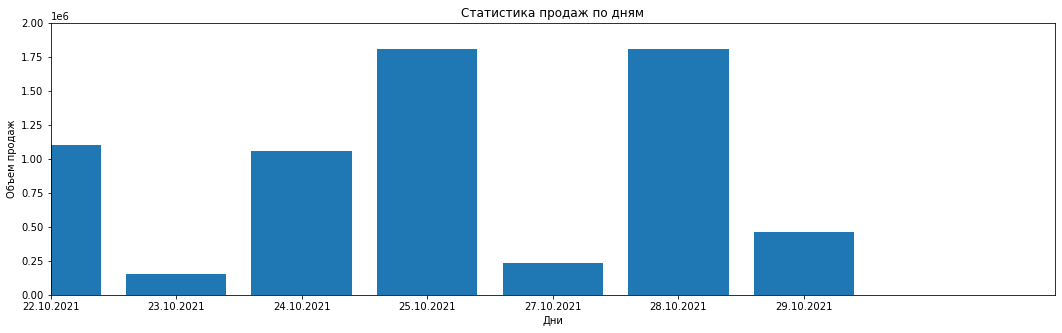

In [102]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(111)
ax.set_xlim([0, 8])
ax.set_ylim([0, 2000000])
ax.set_title('Статистика продаж по дням')
ax.set_xlabel('Дни')
ax.set_ylabel('Объем продаж')
x = df['date']
y = df['total']
ax.bar(x, y)
plt.show()